In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [81]:

from keras.layers import Dense, Flatten, Activation, MaxPooling2D, Lambda, Dropout
from keras.models import Sequential
from keras.layers.core import Lambda
from keras.layers import Conv2D, Cropping2D 
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [82]:
# generator

# read the csv file
driving_df = pd.read_csv('data/driving_log.csv')

In [4]:
driving_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [83]:
images_filenames = []
measurements = [] 

for index, row in driving_df.iterrows():
    filename = row['center'][4:]
    images_filenames.append(filename)
    measurement = float(row['steering'])
    measurements.append(measurement)
    

In [84]:
print(len(images_filenames))
#gray = plt.imshow(images[0], cmap='gray')
#plt.imsave('gray_sample.jpg', gray)

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(images_filenames, measurements, test_size=0.25, random_state=101)

8036


KeyboardInterrupt: 

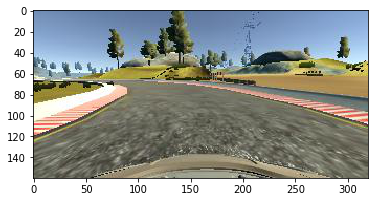

In [9]:
# augmentation

# already done grayscale
# normalization
#def normalize_pixels(data):
#    return (data.astype(float) - 128) / 128
    
#X_train_norm = normalize_pixels(np.asarray(X_train))
#X_valid_norm = normalize_pixels(np.asarray(X_valid))
#X_test_norm = normalize_pixels(np.asarray(X_test))

# create the generator to perform online data augmentation
#image_generator = ImageDataGenerator(
#                                horizontal_flip = True)
#                                zoom_range = 0.1)
#                                rotation_range = 10)
#                                width_shift_range=0.2,
#                                height_shift_range=0.2)

# flip images horizontally to solve left turn bias
#print(X_train[0])
def flip_images(data):
    for i in range(0, len(data)):
        filename = data[i]
        current_path = 'data/IMG/' + filename
        image = mpimg.imread(current_path)
        
        #batch_x_one = cv2.imread(current_path)
                #batch_x_one = cv2.cvtColor(batch_x_one, cv2.COLOR_BGR2GRAY)
                #batch_x_one = np.expand_dims(batch_x_one[:, :], 2)
                #batch_x.append(batch_x_one)
                #batch_y.append(y_data_range[i])
        #plt.imshow(image)
        flipped_image = np.fliplr(image)
        plt.imshow(flipped_image)
        # save image to 'data/IMG/'
        #print(filename)
        plt.savefig('data/IMG/'+'f'+filename)
        
flip_images(X_train)
#X_train_flipped = np.fliplr(X_train)
#y_train_flipped = -y_train

In [67]:
#current_path = 'data/IMG/' + 'f'+X_train[1]
#image = mpimg.imread(current_path)
#plt.imshow(image)
print(len(X_train))

6027


In [85]:
# merge flips images and original images
#d = np.append(a, b, axis=0)
# create flips images filenames

#flips_filenames = 'f'+ x for x in X_train
#function = lambda x: ('f'+x for x in X_train)

#flips_filenames = X_train.apply(function)
flips_filenames = []
for each in X_train:
    flips_filenames.append('f'+each)
    
flips_filenames = np.asarray(flips_filenames)

print(flips_filenames[10])
#X_train_merged = np.append(X_train, )
print(len(flips_filenames))

flips_measurements = - np.asarray(y_train)

fcenter_2016_12_01_13_40_52_780.jpg
6027


In [86]:
# merge

X_train_merged = np.append(X_train, flips_filenames)
y_train_merged = np.append(y_train, flips_measurements)

In [95]:
len(X_train_merged) 
print(X_train_merged[10000])
print(y_train_merged[10000])

fcenter_2016_12_01_13_38_08_163.jpg
0.1831838


In [87]:
def generator(X_data, y_data, batch_size):
    
    num_samples = len(X_data)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = []
            batch_y = []
            X_data_range, y_data_range = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
            if len(X_data_range) < batch_size:
                break
            for i in range(0, batch_size):
                filename = X_data_range[i]
                current_path = 'data/IMG2/' + filename
                batch_x_one = cv2.imread(current_path)
                batch_x_one = cv2.cvtColor(batch_x_one, cv2.COLOR_BGR2GRAY)
                batch_x_one = np.expand_dims(batch_x_one[:, :], 2)
                batch_x.append(batch_x_one)
                batch_y.append(y_data_range[i])
        #batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            batch_x = np.asarray(batch_x)
            #batch_x = batch_x.reshape(-1, 160, 320, 3)
            batch_y = np.asarray(batch_y)
            batch_x, batch_y = shuffle(batch_x, batch_y)
            yield batch_x, batch_y
    
batch_x, batch_y = next(generator(X_train, y_train, 32))

In [88]:
batch_size = 32
epochs = 10

In [89]:
X_train_merged, y_train_merged = shuffle(X_train_merged, y_train_merged)
train_generator = generator(X_train_merged, y_train_merged, batch_size)
valid_generator = generator(X_valid, y_valid, batch_size)

In [90]:
#plt.imshow(batch_x[31], cmap='gray')
print(len(batch_x))
print(len(batch_x[0]))
print(batch_x[0].shape)

32
160
(160, 320, 1)


In [91]:
adam = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999)
len(y_train_merged)


12054

In [92]:
model = Sequential()

# crop the some of the top and bottom to make image more relevant
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,1)))
# doing the normalizaton
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(110,300,1)))
# convolution layer 1, with input: x1 output: x24
model.add(Conv2D(filters=8, kernel_size=(5, 5), padding='same', subsample=(2, 2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
# maxpooling layer 1, with input: x24 output: x24
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# convolution layer 2, with input: x24, output: x36
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='same', subsample=(2, 2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
# maxpooling layer 2, with input: x36 output: x36
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# convolution layer 3, with input: x36, output: x48
model.add(Conv2D(filters=48, kernel_size=(5, 5), padding='same', subsample=(2, 2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
# maxpooling layer 3, with input: x48, output: x48
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# flatten the inputs, prepared for the fully connected layer
model.add(Flatten())
# fully connected layer 1, with input x48, output: 1024
model.add(Dense(1024))
#model.add(BatchNormalization())
model.add(Activation('relu'))
# apply regularization, with a dropout probability of 50%
model.add(Dropout(0.5))
# fully connected layer 2, with input 1024, output: 256
model.add(Dense(256))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dense(128))
#model.add(Activation('relu'))
# output layer, with input: 256, output 1
model.add(Dense(1))

model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_4 (Cropping2D)    (None, 90, 320, 1)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 90, 320, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 160, 8)        208       
_________________________________________________________________
activation_16 (Activation)   (None, 45, 160, 8)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 44, 159, 8)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 80, 16)        3216      
_________________________________________________________________
activation_17 (Activation)   (None, 22, 80, 16)        0         
__________

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=8, kernel_size=(5, 5), padding="same", strides=(2, 2))`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=16, kernel_size=(5, 5), padding="same", strides=(2, 2))`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=48, kernel_size=(5, 5), padding="same", strides=(2, 2))`


In [93]:

model.fit_generator(train_generator, 
                    samples_per_epoch=len(X_train_merged), 
                    steps_per_epoch=len(X_train_merged)/batch_size,
                    validation_data=valid_generator,
                    validation_steps=len(X_valid)/batch_size,
                    verbose=1,
                    shuffle=True,
                    nb_epoch=epochs)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=12054, validation_data=<generator..., validation_steps=62.78125, verbose=1, shuffle=True, epochs=10)`
  if __name__ == '__main__':


Epoch 1/10


ValueError: Error when checking input: expected cropping2d_4_input to have 4 dimensions, but got array with shape (32, 1)

In [ ]:
model.save('model2.h5')